In [154]:
from skimage import color, io, measure, img_as_ubyte, util, data, morphology
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, matrix_transform, SimilarityTransform, EuclideanTransform, warp, swirl
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.decomposition import PCA
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, label2rgb
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v, prewitt, median
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening, square
from skimage.segmentation import clear_border
from scipy.stats import norm
from scipy.spatial import distance
import scipy.io as sio
import glob
import os
import SimpleITK as sitk
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import correlate

In [155]:
zebra_image = io.imread('zebra/Zebra.png')
white_stripes_mask = io.imread('zebra/Zebra_whiteStripes.png')
black_stripes_mask = io.imread('zebra/Zebra_blackStripes.png')
analysis_mask = io.imread('zebra/zebra_MASK.png', as_gray=True)

white_stripes_pixels = zebra_image[white_stripes_mask > 0]
black_stripes_pixels = zebra_image[black_stripes_mask > 0]

mu_white = np.mean(white_stripes_pixels)
std_white = np.std(white_stripes_pixels)

mu_black = np.mean(black_stripes_pixels)
std_black = np.std(black_stripes_pixels)

print(f'White stripes: mean = {mu_white}, std = {std_white}')
print(f'Black stripes: mean = {mu_black}, std = {std_black}')





White stripes: mean = 186.61915367483297, std = 23.631962580548727
Black stripes: mean = 33.39007092198582, std = 36.733454270497404


In [156]:
black_stripes_range = (mu_black - 2 * std_black, mu_black + 2 * std_black)

for test_value in np.linspace(mu_black, mu_white, 1000):
    if norm.pdf(test_value, mu_white, std_white) > norm.pdf(test_value, mu_black, std_black):
        optimal_threshold = test_value
        break

print(f'Optimal Threshold: {optimal_threshold}')

test_value = (mu_black + mu_white) / 2
if norm.pdf(test_value, mu_white, std_white) > norm.pdf(test_value, mu_black, std_black):
    print(f"For value {test_value} the class is white stripes")
else:
    print(f"For value {test_value} the class is black stripes")

Optimal Threshold: 124.19249033108042
For value 110.0046122984094 the class is black stripes


In [157]:
zebra_image = io.imread('zebra/Zebra.png', as_gray=True)
white_stripes_mask = io.imread('zebra/Zebra_whiteStripes.png', as_gray=True)
black_stripes_mask = io.imread('zebra/Zebra_blackStripes.png', as_gray=True)
analysis_mask = io.imread('zebra/zebra_MASK.png', as_gray=True)


white_stripe_values = zebra_image[white_stripes_mask > 0]
black_stripe_values = zebra_image[black_stripes_mask > 0]
mu_white = np.mean(white_stripe_values)
std_white = np.std(white_stripe_values)
mu_black = np.mean(black_stripe_values)
std_black = np.std(black_stripe_values)
classified_image = np.zeros_like(zebra_image)
classified_image[(zebra_image > optimal_threshold) & (analysis_mask > 0)] = 1
white_pixel_count = np.sum(classified_image)



print(f"white stripe pixels: {white_pixel_count}")

white stripe pixels: 0.0


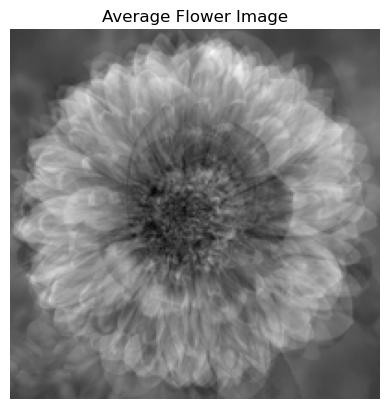

Total variance first: 56.22227887588067
The two flowers furthest flower10.jpg and flower12.jpg


In [158]:
flower_images = []
for i in range(1, 16):
    img = io.imread(f'flowers/flower{i:02d}.jpg')
    gray_img = color.rgb2gray(img)  # Convert to grayscale
    flower_images.append(gray_img)

flower_images = np.array(flower_images)

average_flower = np.mean(flower_images, axis=0)

# Display the average flower image
plt.imshow(average_flower, cmap='gray')
plt.title('Average Flower Image')
plt.axis('off')
plt.show()

n_samples, h, w = flower_images.shape
flattened_images = flower_images.reshape(n_samples, h * w)

pca = PCA(n_components=5)
pca.fit(flattened_images)

flower_pca = pca.transform(flattened_images)

explained_variance_ratio = pca.explained_variance_ratio_

print(f"Total variance first: {explained_variance_ratio[0] * 100}")

first_pc_values = flower_pca[:, 0]
max_distance = 0
flower_pair = (0, 0)

for i in range(len(first_pc_values)):
    for j in range(i + 1, len(first_pc_values)):
        distance = np.abs(first_pc_values[i] - first_pc_values[j])
        if distance > max_distance:
            max_distance = distance
            flower_pair = (i, j)

print(f"The two flowers furthest flower{flower_pair[0]+1:02d}.jpg and flower{flower_pair[1]+1:02d}.jpg")

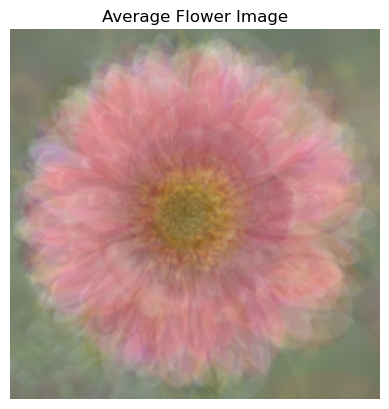

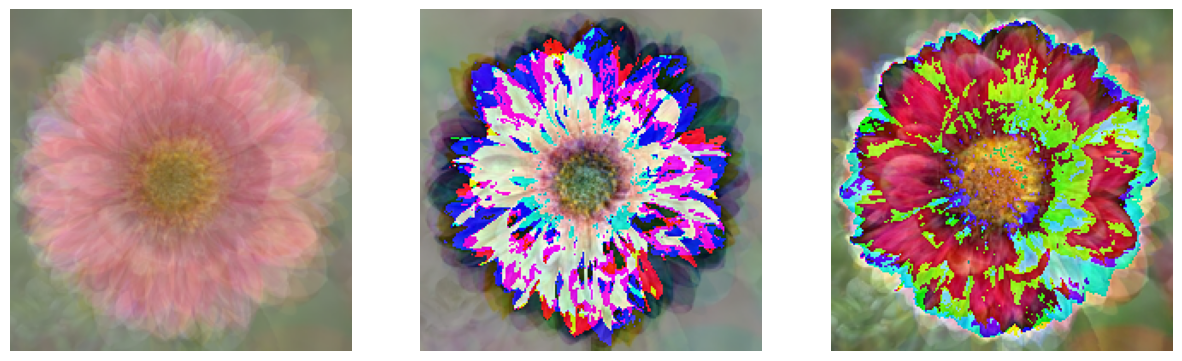

clostest 08


In [159]:
flower_images = []
for i in range(1, 16):
    img = io.imread(f'flowers/flower{i:02d}.jpg')
    flower_images.append(img)
ideal_flower = io.imread('flowers/idealflower.jpg')
flower_images = np.array(flower_images)
average_flower = np.mean(flower_images, axis=0).astype(np.uint8)
plt.imshow(average_flower)
plt.title('Average Flower Image')
plt.axis('off')
plt.show()
n_samples, h, w, c = flower_images.shape
flattened_images = flower_images.reshape(n_samples, h * w * c)
pca = PCA(n_components=5)
pca.fit(flattened_images)

synth_image_plus = average_flower.flatten() + 3 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0, :]
synth_image_minus = average_flower.flatten() - 3 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0, :]

synth_image_plus = synth_image_plus.reshape(h, w, c).astype(np.uint8)
synth_image_minus = synth_image_minus.reshape(h, w, c).astype(np.uint8)
ideal_flower_flat = ideal_flower.flatten().reshape(1, -1)
ideal_flower_projection = pca.transform(ideal_flower_flat)
flower_projections = pca.transform(flattened_images)

distances = np.abs(flower_projections[:, 1] - ideal_flower_projection[0, 1])
closest_flower_index = np.argmin(distances)

closest_flower = flower_images[closest_flower_index]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(average_flower)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(synth_image_plus)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(synth_image_minus)
plt.axis('off')

plt.show()

print(f'clostest {closest_flower_index + 1:02d}')

In [160]:

data_name = 'winePCA/wine-data.txt'
x_org = np.loadtxt(data_name, comments="%")

x = x_org[:, :13]
producer = x_org[:, 13]


means = np.mean(x, axis=0)
ranges = np.ptp(x, axis=0)  # ptp stands for "peak to peak" and calculates max - min
x_normalized = (x - means) / ranges

alcohol_first_wine_normalized = x_normalized[0, 0]
print(f'The alcohol level: {alcohol_first_wine_normalized}')

# Compute the covariance matrix
cov_matrix = np.cov(x_normalized, rowvar=False)


average_cov_value = np.mean(cov_matrix)
print(f'The average value cv {average_cov_value}')


eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

x_pca = x_normalized @ eigenvectors

first_pc = x_pca[:, 0]
avg_pc1_producer1 = np.mean(first_pc[producer == 1])
avg_pc1_producer2 = np.mean(first_pc[producer == 2])


difference = avg_pc1_producer2 - avg_pc1_producer1

print(f'The difference between the average projected values :{difference}')
difference = np.max(first_pc) - np.min(first_pc)
print(f'The difference between the maximum and minimum : {difference}')


explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.sum(explained_variance[:5])
print(f'The first five principal components explain {cumulative_explained_variance * 100}')

The alcohol level: 0.3235215848610307
The average value cv 0.006240233570354023
The difference between the average projected values :0.48273699841405826
The difference between the maximum and minimum : 1.7509334569362713
The first five principal components explain 81.27348585863359


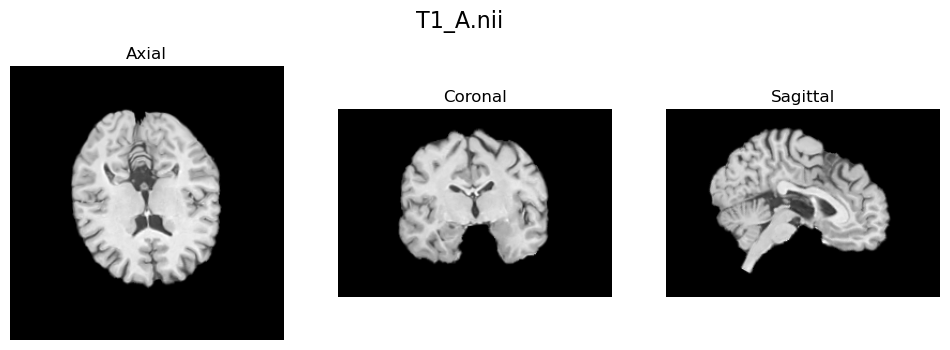

In [161]:
# Function to display orthogonal views
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

# Function to create a rotation matrix
def rotation_matrix(pitch, roll, yaw):
    """
    Returns a 4x4 affine transformation matrix for the rotation specified by
    pitch, roll, and yaw angles (in degrees).
    """
    # Convert angles from degrees to radians
    pitch = np.deg2rad(pitch)
    roll = np.deg2rad(roll)
    yaw = np.deg2rad(yaw)

    # Define the rotation matrices for each axis
    Rx = np.array([
        [1, 0, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch), 0],
        [0, np.sin(pitch), np.cos(pitch), 0],
        [0, 0, 0, 1]
    ])

    Ry = np.array([
        [np.cos(roll), 0, np.sin(roll), 0],
        [0, 1, 0, 0],
        [-np.sin(roll), 0, np.cos(roll), 0],
        [0, 0, 0, 1]
    ])

    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0, 0],
        [np.sin(yaw), np.cos(yaw), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    # Compute the combined rotation matrix
    R = np.dot(np.dot(Rx, Ry), Rz)

    return R


image_path = 'brain/T1_brain_template.nii.gz'
vol_sitk = sitk.ReadImage(image_path)


yaw = 10
pitch = -30
rot_matrix_yaw = rotation_matrix(0, 0, yaw)[:3, :3]
rot_matrix_pitch = rotation_matrix(pitch, 0, 0)[:3, :3]

transform_yaw = sitk.AffineTransform(3)
centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image)
transform_yaw.SetCenter(centre_world)
transform_yaw.SetMatrix(rot_matrix_yaw.flatten())

vol_yaw_sitk = sitk.Resample(vol_sitk, transform_yaw)

transform_pitch = sitk.AffineTransform(3)
transform_pitch.SetCenter(centre_world)
transform_pitch.SetMatrix(rot_matrix_pitch.flatten())

vol_yaw_pitch_sitk = sitk.Resample(vol_yaw_sitk, transform_pitch)


imshow_orthogonal_view(vol_yaw_pitch_sitk, title='T1_A.nii')

Normalized Correlation Coefficient: 0.0780


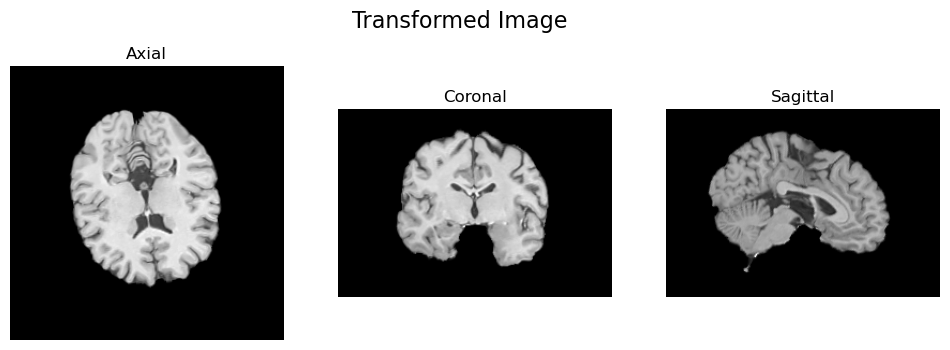

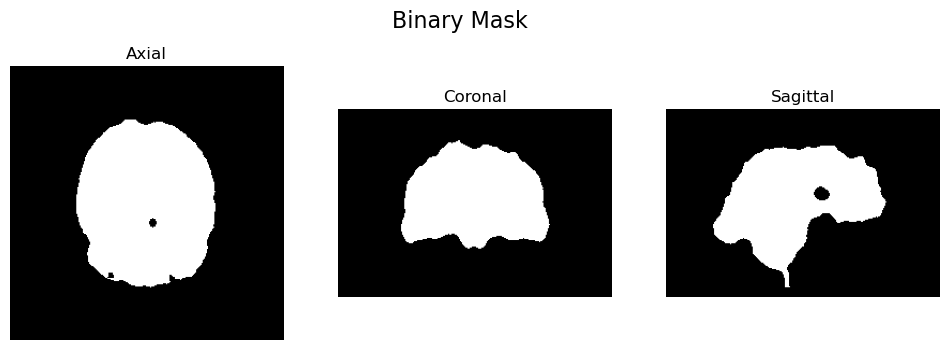

In [162]:
yaw = 10
pitch = -30
transform = sitk.AffineTransform(3)
center = np.array(vol_sitk.GetSize()) / 2.0
center_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(center)
transform.SetCenter(center_world)
rotation = rotation_matrix(pitch, 0, yaw)[:3, :3]
transform.SetMatrix(rotation.flatten())
moving_image = sitk.Resample(vol_sitk, transform)


imshow_orthogonal_view(moving_image, title='Transformed Image')

image_array = sitk.GetArrayFromImage(vol_sitk)
thresh = threshold_otsu(image_array)
binary_mask = image_array > thresh


structuring_element = morphology.ball(5)
binary_mask_closed = closing(binary_mask, structuring_element)
binary_mask_eroded = erosion(binary_mask_closed, morphology.ball(3))
binary_mask_sitk = sitk.GetImageFromArray(binary_mask_eroded.astype(np.uint8))
binary_mask_sitk.CopyInformation(vol_sitk)


template_array = sitk.GetArrayFromImage(vol_sitk)
moving_array = sitk.GetArrayFromImage(moving_image)
masked_template = template_array * binary_mask_eroded
masked_moving = moving_array * binary_mask_eroded

def compute_ncc(template, moving):
    mask_indices = np.nonzero(template)
    IF = template[mask_indices]
    IM = moving[mask_indices]
    
    mean_IF = np.mean(IF)
    mean_IM = np.mean(IM)
    
    numerator = np.sum((IF - mean_IF) * (IM - mean_IM))
    denominator = np.sqrt(np.sum((IF - mean_IF) ** 2) * np.sum((IM - mean_IM) ** 2))
    
    return numerator / denominator

ncc_value = compute_ncc(masked_template, masked_moving)
print(f'Normalized Correlation Coefficient: {ncc_value:.4f}')
imshow_orthogonal_view(binary_mask_sitk, title='Binary Mask')

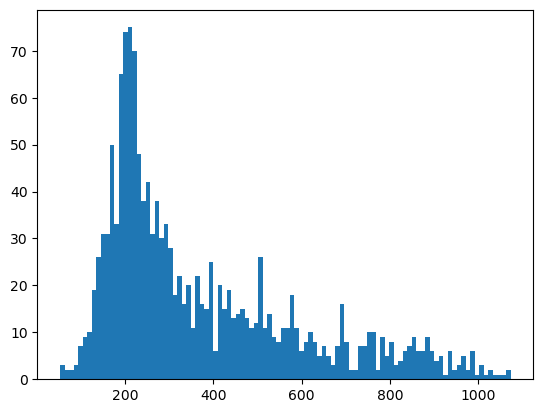

Mean : 373.6496250852079
Std: 223.79913867096596


In [163]:
import cv2

dicom_file = 'vertebraCT/1-353.dcm'
mask_file = 'vertebraCT/vertebra_gt.png'

dicom_data = dicom.dcmread(dicom_file)
image = dicom_data.pixel_array
hu_image = image * dicom_data.RescaleSlope + dicom_data.RescaleIntercept


mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)


threshold = 200
binary_image = hu_image > threshold
selem = disk(3)
closed_image = closing(binary_image, selem)


labeled_image = measure.label(closed_image)
props = measure.regionprops(labeled_image)


min_area = 500
filtered_image = np.zeros_like(labeled_image)
for prop in props:
    if prop.area >= min_area:
        for coord in prop.coords:
            filtered_image[coord[0], coord[1]] = 1

vertebra_hu_values = hu_image[filtered_image == 1]
mean_hu = np.mean(vertebra_hu_values)
std_hu = np.std(vertebra_hu_values)


plt.hist(vertebra_hu_values, bins=100)
plt.show()

print(f'Mean : {mean_hu}')
print(f'Std: {std_hu}')

In [164]:
def dice_score(img, gt_bin):
    intersection = np.logical_and(img, gt_bin)
    return 2. * intersection.sum() / (img.sum() + gt_bin.sum())

dice = dice_score(filtered_image, hu_image)
print(f'DICE score: {dice}')


DICE score: -1.7665522301276872e-05


In [165]:


# Perform BLOB analysis
labeled_image = measure.label(closed_image)
blob_properties = measure.regionprops(labeled_image)

# Compute the area of each BLOB
blob_areas = [prop.area for prop in blob_properties]

# Filter BLOBs with area larger than 500 pixels
filtered_blob_areas = [area for area in blob_areas if area > 500]
# Create a new mask from the filtered BLOBs
print(blob_areas)

[37.0, 20.0, 27.0, 6.0, 51.0, 134.0, 77.0, 153.0, 1.0, 1.0, 1.0, 110.0, 3.0, 324.0, 21.0, 1467.0, 115.0, 2.0, 1.0, 1.0, 114.0, 111.0, 112.0, 2.0, 10.0, 14.0, 1.0, 1.0, 1.0, 2.0]


In [166]:
def gradient_x1(x1, x2):
    return 2 * x1 - x2 + 3 * x1**2

def gradient_x2(x1, x2):
    return -x1 + 6 * x2
alpha = 0.07
x1, x2 = 4.0, 3.0
iterations = 0
threshold = 0.20

while True:
    
    cost = x1**2 - x1 * x2 + 3 * x2**2 + x1**3
    
    if cost < threshold:
        break
    
    x1 = x1 - alpha * gradient_x1(x1, x2)
    x2 = x2 - alpha * gradient_x2(x1, x2)
    
    iterations += 1

print(f'iterations: {iterations}')



iterations: 6


In [167]:
alpha = 0.07
x1, x2 = 4.0, 3.0

for _ in range(5):
    
    grad_x1 = gradient_x1(x1, x2)
    grad_x2 = gradient_x2(x1, x2)
    
    
    x1 = x1 - alpha * grad_x1
    x2 = x2 - alpha * grad_x2

print(f'x1: {x1:.4f}')



x1: 0.3014


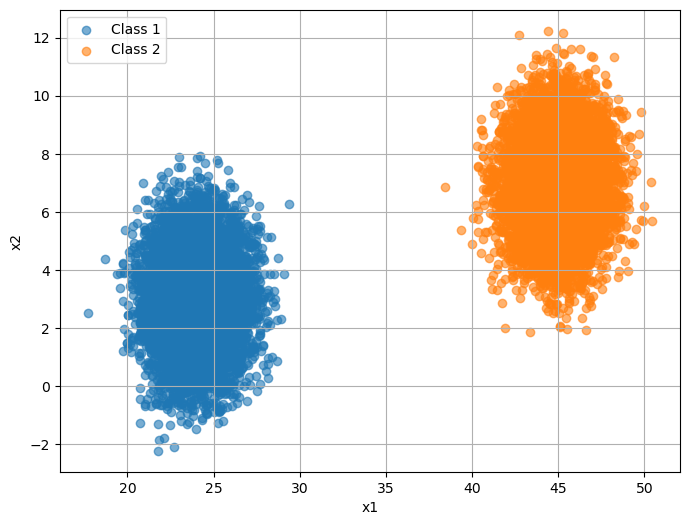

In [168]:
# Define the mean values and covariance matrix
mean_class1 = np.array([24, 3])
mean_class2 = np.array([45, 7])
cov = np.array([[2, 0], [0, 2]])

# Generate sample data
np.random.seed(0)  # For reproducibility
class1_samples = np.random.multivariate_normal(mean_class1, cov, 10000)
class2_samples = np.random.multivariate_normal(mean_class2, cov, 10000)

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(class1_samples[:, 0], class1_samples[:, 1], label='Class 1', alpha=0.6)
plt.scatter(class2_samples[:, 0], class2_samples[:, 1], label='Class 2', alpha=0.6)




plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

In [169]:
image = io.imread('pots/pots.jpg')
red_channel = image[:, :, 0]


filtered_red = median(red_channel, square(10))
threshold = 200
foreground = filtered_red > threshold
foreground_pixel_count = np.sum(foreground)

print(f'Number of foreground pixels: {foreground_pixel_count}')


Number of foreground pixels: 7385
